# Intro
In this notebook, we check and visualize different metrics to evaluate a cognitive map.

In [2]:
%load_ext autoreload
%autoreload 2
#from system.tests.eval_cogmap import cognitive_map_coverage
from system.bio_model.cognitive_map import LifelongCognitiveMap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


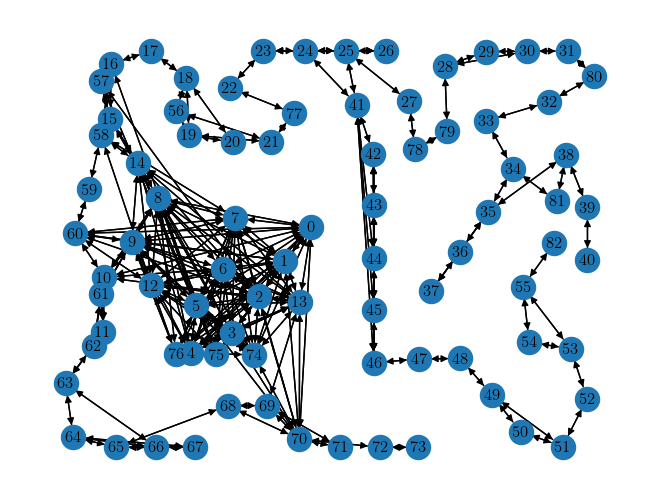

In [2]:
env_model = "Savinov_val3"
cogmap = LifelongCognitiveMap(reachability_estimator=None, load_data_from="after_exploration.gpickle")
cogmap.draw()

# Get coverage for all maps

In [33]:
from system.controller.reachability_estimator.reachability_estimation import reachability_estimator_factory
from system.bio_model.cognitive_map import LifelongCognitiveMap

def scalar_coverage(filename, env_model):
    re = reachability_estimator_factory('view_overlap', env_model=env_model)
    cogmap = LifelongCognitiveMap(reachability_estimator=None, load_data_from=filename, debug=False)
    pcs = cogmap.node_network.nodes.keys()

    _, coverage = cognitive_map_coverage(pcs, re, env_model)
    coverage = np.any(coverage, axis=1)
    return sum(coverage) / len(coverage)

import os
for filename in os.listdir("../system/bio_model/data/cognitive_map"):
    match filename.split("."):
        case (env_model, _type, "gpickle"):
            coverage = scalar_coverage(filename, env_model)
        case (_type, "gpickle"):
            coverage = scalar_coverage(filename, "Savinov_val3")
    print(f'{filename}: {coverage:.2%} coverage')

cognitive_map_partial_2.gpickle: 43.75% coverage
.DS_Store: 43.75% coverage
disjoint.gpickle: 57.50% coverage
handcrafted.gpickle: 43.75% coverage
after_lifelong_learning.gpickle: 43.75% coverage
cognitive_map_full.gpickle: 21.25% coverage
linear_sunburst.handcrafted.gpickle: 98.78% coverage
linear_sunburst.after_lifelong_learning.gpickle: 98.78% coverage
after_exploration.gpickle.new: 98.78% coverage
after_exploration.gpickle: 97.50% coverage
cognitive_map_partial.gpickle: 26.25% coverage
linear_sunburst.after_exploration+re--network.gpickle: 98.78% coverage
linear_sunburst.after_exploration.gpickle: 96.34% coverage
cognitive_map_partial_3.gpickle: 31.25% coverage


# Detailed coverage

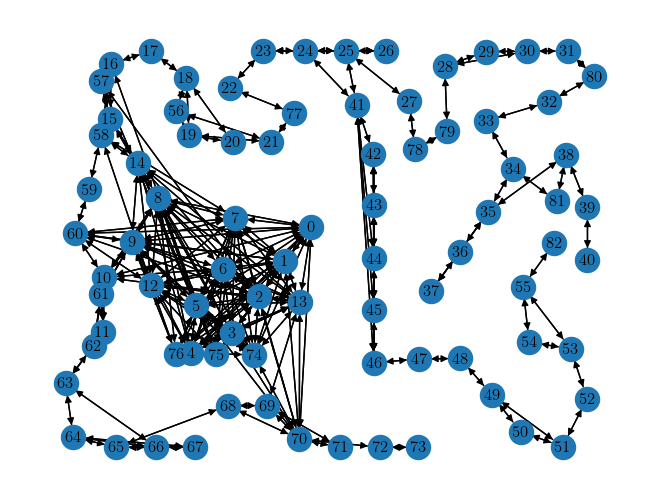

In [34]:
from system.bio_model.cognitive_map import LifelongCognitiveMap
env_model = "Savinov_val3"
cogmap = LifelongCognitiveMap(reachability_estimator=None, load_data_from="after_exploration.gpickle")
pcs = cogmap.node_network.nodes.keys()

In [37]:
from system.controller.reachability_estimator.reachability_estimation import reachability_estimator_factory
re = reachability_estimator_factory('view_overlap', env_model=env_model)

In [38]:
grid, coverage = cognitive_map_coverage(pcs, re, env_model)

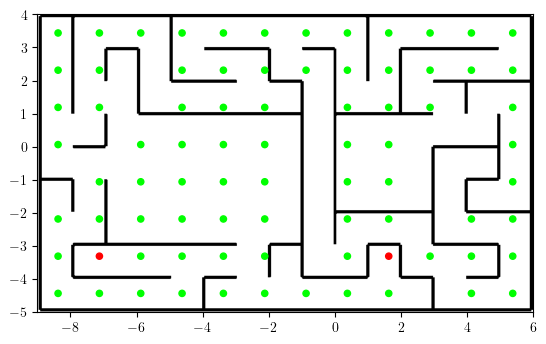

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from system.plotting.plotHelper import add_environment

def draw_grid(grid, coverage, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    add_environment(ax, env_model)
    ax.scatter([g[0] for g in grid], [g[1] for g in grid], s=20, c=['#0f0' if c else 'r' for c in coverage])
draw_grid(grid, np.any(coverage, axis=1))

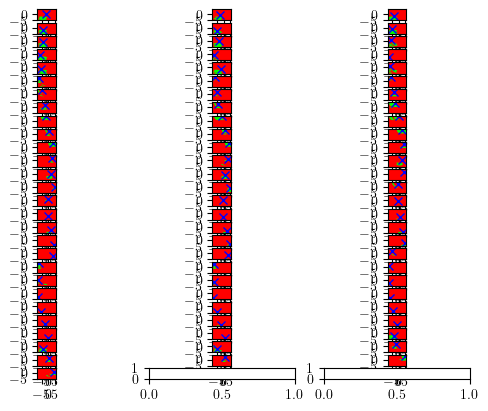

In [43]:
fig, axes = plt.subplots(28, 3)
axes = axes.flatten()
pcs = list(pcs)
for i in range(82):
    axes[i].plot(*pcs[i].pos, 'bx')
    draw_grid(grid, coverage[:, i], axes[i])

# RE-based metrics

In [44]:
!ls ../system/bio_model/data/cognitive_map/

after_exploration.gpickle
after_exploration.gpickle.new
after_lifelong_learning.gpickle
cognitive_map_full.gpickle
cognitive_map_partial_2.gpickle
cognitive_map_partial_3.gpickle
cognitive_map_partial.gpickle
disjoint.gpickle
handcrafted.gpickle
linear_sunburst.after_exploration.gpickle
linear_sunburst.after_exploration+re--network.gpickle
linear_sunburst.after_lifelong_learning.gpickle
linear_sunburst.handcrafted.gpickle


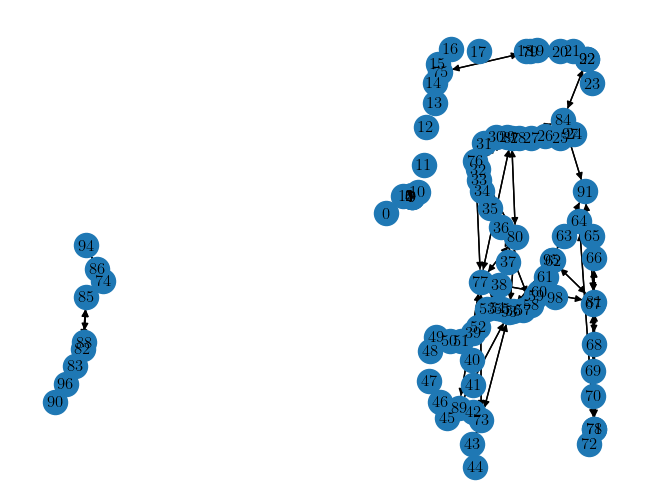

In [8]:
from system.controller.reachability_estimator.reachability_estimation import reachability_estimator_factory
env_model = "Savinov_val3"
cogmap = LifelongCognitiveMap(reachability_estimator=None, load_data_from="handcrafted.gpickle")
cogmap.draw()

In [9]:
from system.controller.reachability_estimator.reachability_estimation import (
    ViewOverlapReachabilityEstimator, NetworkReachabilityEstimator, SimulationReachabilityEstimator
)
from system.controller.reachability_estimator.training.train_multiframe_dst import Hyperparameters
from system.controller.reachability_estimator.ReachabilityDataset import SampleConfig
from system.controller.simulation.pybullet_environment import PybulletEnvironment

#env = PybulletEnvironment(env_model=env_model, visualize=False, contains_robot=False).__enter__()
view_re = ViewOverlapReachabilityEstimator(env_model=env_model)
net_re = NetworkReachabilityEstimator.from_file('re_mse_weights.50', config=SampleConfig(grid_cell_spikings=True))
#sim_re = SimulationReachabilityEstimator(env)

In [68]:
from tqdm import tqdm

connections = []
for (p1, p2), attrs in tqdm(cogmap.node_network.edges.items()):
    attrs = dict(attrs)
    attrs['sim_success'] = sim_re.reachability_factor(p1, p2)
    attrs['view_success'] = view_re.reachability_factor(p1, p2)
    attrs['net_success'] = net_re.reachability_factor(p1, p2)
    connections.append(attrs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [31:55<00:00, 14.74s/it]


In [59]:
%psource p.angle

# p.angle.fget
@property
def angle(self):
    return NotImplemented # TODO Pierre: place cells were saved without angles


In [69]:
connections[0]

{'weight': 0.07983817402601277,
 'connectivity_probability': 0.9095744680851063,
 'mu': 0.06768695678173486,
 'sigma': 0.006123724356957945,
 'sim_success': 1.0,
 'view_success': 0.895,
 'net_success': 0.5938802361488342}

In [70]:
import pandas as pd
df = pd.DataFrame(connections)
df

,weight,connectivity_probability,mu,sigma,sim_success,view_success,net_success,length
0,0.079838,0.909574,0.067687,0.006124,1.0,0.895,0.593880,NaN
1,0.196303,0.864488,0.195854,0.010607,1.0,0.925,0.608306,NaN
2,0.208707,0.950000,0.200001,0.006708,1.0,0.840,0.742847,NaN
3,0.096325,0.950000,0.105047,0.007500,1.0,0.815,0.579855,NaN
4,0.079838,0.909574,0.067687,0.006124,1.0,0.895,0.002795,NaN
...,...,...,...,...,...,...,...,...
125,0.483250,0.936170,0.479382,0.010607,1.0,0.745,0.852564,NaN
126,0.525413,0.800000,0.500000,0.015000,0.0,0.610,0.000069,130.0
127,0.486854,0.800000,0.500000,0.015000,0.0,0.465,0.052674,87.0
128,0.504482,0.800000,0.500000,0.015000,0.0,0.000,0.003385,NaN


In [4]:
max(df['net_success'])

0.9966136813163756

In [10]:
(df['view_success'] >= view_re.threshold_reachable).cov(df['sim_success'])

0.101252236135957

In [6]:
df[df['net_success'] >= 0.4]

,Unnamed: 0,weight,connectivity_probability,mu,sigma,sim_success,view_success,net_success,length
0,0,0.079838,0.909574,0.067687,0.006124,1.0,0.895,0.593880,NaN
1,1,0.196303,0.864488,0.195854,0.010607,1.0,0.925,0.608306,NaN
2,2,0.208707,0.950000,0.200001,0.006708,1.0,0.840,0.742847,NaN
3,3,0.096325,0.950000,0.105047,0.007500,1.0,0.815,0.579855,NaN
5,5,0.000139,0.950000,0.002630,0.007500,1.0,0.945,0.989487,NaN
6,6,-0.013136,0.950000,0.003873,0.007500,1.0,0.935,0.984510,NaN
8,8,0.044104,0.409294,0.015490,0.015000,1.0,0.995,0.984510,NaN
14,14,0.701661,0.924524,0.698349,0.008660,1.0,0.865,0.872099,NaN
15,15,0.701661,0.924524,0.698349,0.008660,1.0,0.750,0.684866,NaN
16,16,0.256564,0.557831,0.263052,0.015000,1.0,0.840,0.736946,NaN


In [14]:
%pdef cognitive_map_coverage

 cognitive_map_coverage(
    place_cells: list[system.bio_model.place_cell_model.PlaceCell],
    reachability_estimator: system.controller.reachability_estimator.reachability_estimation.ReachabilityEstimator,
    map_name: Literal['Savinov_val3', 'Savinov_val2', 'Savinov_test7', 'linear_sunburst', 'obstacle_map_0', 'obstacle_map_1', 'plane'],
)
 

In [19]:
import pandas as pd
from system.controller.reachability_estimator.reachability_estimation import (
    ViewOverlapReachabilityEstimator, NetworkReachabilityEstimator, SimulationReachabilityEstimator
)
from system.controller.reachability_estimator.training.train_multiframe_dst import Hyperparameters
from system.controller.reachability_estimator.ReachabilityDataset import SampleConfig

from tqdm import tqdm

def cognitive_map_agreement(
    cogmap: 'CognitiveMap',
    map_name: 'AllowedMapName',
):
    view_re = ViewOverlapReachabilityEstimator(env_model=env_model)
    net_re = NetworkReachabilityEstimator.from_file('re_mse_weights.50', config=SampleConfig(grid_cell_spikings=True))
    connections = []
    for (p1, p2), attrs in tqdm(cogmap.node_network.edges.items()):
        attrs = dict(attrs)
        attrs['view_success'] = view_re.reachability_factor(p1, p2)
        attrs['net_success'] = net_re.reachability_factor(p1, p2)
        connections.append(attrs)
    df = pd.DataFrame(connections)
    return (df['view_success'] >= view_re.threshold_reachable).cov(df['net_success'] >= net_re.threshold_reachable)

In [73]:
df.to_csv('handcrafted.gpickle.connections.csv')

In [3]:
import pandas as pd
df = pd.read_csv('handcrafted.gpickle.connections.csv')

In [61]:
env.__exit__(None, None, None)

# Pure graph metrics

In [10]:
network = cogmap.node_network

nodes = list(network.nodes)
nodes_visited = {node: 0 for node in nodes}
edges_visited = {edge: 0 for edge in network.edges}

In [17]:
import networkx as nx
from itertools import pairwise

for i in range(len(nodes)):
    for j in range(i, len(nodes)):
        path = nx.shortest_path(network, source=nodes[i], target=nodes[j])
        for node in path:
            nodes_visited[node] += 1
        for n1, n2 in pairwise(path):
            edges_visited[n1, n2] += 1

/tmp/ipykernel_68269/680024668.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


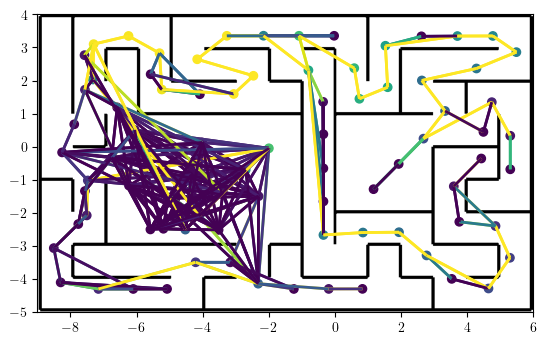

In [30]:
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib
from system.plotting.plotHelper import add_environment
fig, ax = plt.subplots()
add_environment(ax, env_model)
pos, values = [tuple(pc.pos) for pc in nodes_visited.keys()], list(nodes_visited.values())
ax.scatter(*zip(*pos), c=values)

cmap = matplotlib.cm.get_cmap('viridis')
lines, values = [[ start.pos, stop.pos ] for start, stop in edges_visited.keys() ], list(map(cmap, edges_visited.values()))
lc = mc.LineCollection(lines, colors=values, linewidths=2)
ax.add_collection(lc)

In [32]:
from scipy.stats import variation

print(variation(list(nodes_visited.values())))
print(variation(list(edges_visited.values())))

1.0653935349761308
2.344706480256033


# The map as a map

In [14]:
import numpy as np
import networkx as nx

def average(li):
    return sum(li) / len(li)

def to_mst(graph):
    graph = cogmap.node_network
    graph = graph.to_undirected()

    for (p1, p2), edge_data in graph.edges.items():
        edge_data['distance'] = np.linalg.norm(np.array(p1.pos) - np.array(p2.pos))

    return nx.minimum_spanning_tree(graph, weight='distance')

def mean_distance_between_nodes(cogmap):
    mst = to_mst(cogmap.node_network)
    return average([edge['distance'] for edge in mst.edges.values()])

print(mean_distance_between_nodes(cogmap))

1.0516383797663085


In [34]:
import numpy as np
from system.controller.simulation.environment.map_occupancy import MapLayout

def all_unobstructed_lines(cogmap, env_model):
    graph = cogmap.node_network
    map = MapLayout(env_model)

    if len(graph.edges) == 0:
        return []
    lines = np.zeros((len(graph.edges), 4))
    for i, (x1, x2) in enumerate(graph.edges):
        lines[i, 0:2] = x1.pos
        lines[i, 2:4] = x2.pos
    collides = map.no_touch_batch(lines)
    return collides

def unobstructed_lines(cogmap, env_model):
    return average(all_unobstructed_lines(cogmap, env_model))

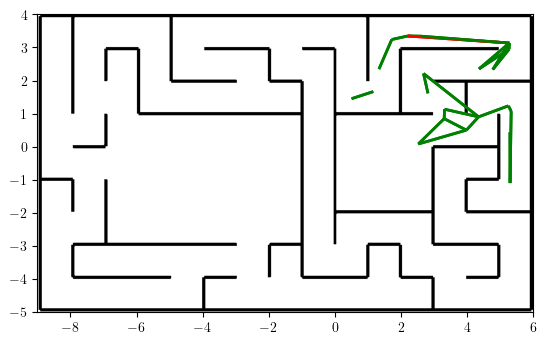

In [37]:
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from system.plotting.plotHelper import add_environment

cogmap = LifelongCognitiveMap(load_data_from=f"artifacts/vo_0.5_r0.4.gpickle", reachability_estimator=None)
collides = all_unobstructed_lines(cogmap, env_model)

fig, ax = plt.subplots()
add_environment(ax, env_model)
lines = [[ start.pos, stop.pos ] for start, stop in cogmap.node_network.edges ]
colors = { True: 'g', False: 'r'}
lc = mc.LineCollection(lines, colors=[ colors[collide] for collide in collides ], linewidths=2)
ax.add_artist(lc)

# All metrics for all maps

In [20]:
import os
import sys
from system.controller.reachability_estimator.reachability_estimation import reachability_estimator_factory
from system.bio_model.cognitive_map import LifelongCognitiveMap

df = {'map_name': [], 'agreement': [], 'correct_nodes': [], 'average_distance': []}

for filename in os.listdir("../system/bio_model/data/cognitive_map"):
    print('Processing', filename, '...', file=sys.stderr)
    match filename.split("."):
        case (env_model, _type, "gpickle"):
            pass
        case (_type, "gpickle"):
            env_model = "Savinov_val3"
        case _:
            continue
    cogmap = LifelongCognitiveMap(load_data_from=filename, reachability_estimator=None)
    re = reachability_estimator_factory('view_overlap', env_model=env_model)
    df['map_name'].append(filename)
    _, coverage = cognitive_map_coverage(cogmap.node_network.nodes.keys(), re, env_model)
    coverage = np.any(coverage, axis=1)
    df['coverage'].append(sum(coverage) / len(coverage))
    df['agreement'].append(cognitive_map_agreement(cogmap))
df = pd.DataFrame(df)
df

Processing cognitive_map_partial_2.gpickle ...


KeyboardInterrupt: 

In [28]:
for i in range(0, 10+1):
    threshold = i / 10
    cogmap = LifelongCognitiveMap(load_data_from=f"artifacts/vo_0.5_r{threshold}.gpickle", reachability_estimator=None)
    print(threshold, ':', unobstructed_lines(cogmap, 'Savinov_val3'))

0.0 : 0.22380952380952382
0.1 : 0.7142857142857143
0.2 : 0.7317073170731707
0.3 : 0.9333333333333333
0.4 : 0.9565217391304348
0.5 : nan
0.6 : nan
0.7 : nan
0.8 : nan
0.9 : nan
1.0 : nan


# Map generated with the simulation RE

In [3]:
env_model = "final_layout"
cogmap = LifelongCognitiveMap(reachability_estimator=None, load_data_from="final_layout.after_exploration+handcrafted.gpickle")

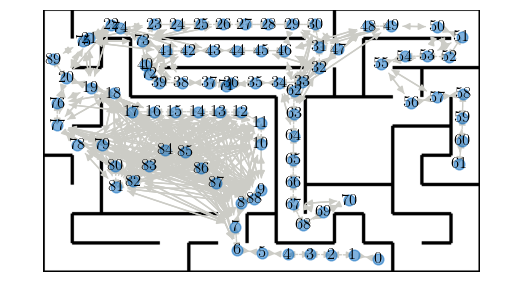

In [5]:
from system.plotting.plotHelper import environment_plot
from system.plotting.plotResults import plotCognitiveMap

ax = environment_plot(env_model)
plotCognitiveMap(ax, cogmap, with_labels=True)

In [ ]:
with open('../system/bio_model/data/cognitive_map/')